# Set up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm.notebook import tqdm
from functools import reduce
import json

torch.set_default_tensor_type('torch.cuda.FloatTensor')

# Modularización

## General

In [2]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]          # Paleta de colores Rojo - Naranja - Verdes - Azules - Morado

sc = MinMaxScaler()

def medirPrecision(model, dataX, dataY, eficiencia):

  model.eval()
  train_predict = model(dataX)

  data_predict = train_predict.data.cpu().numpy()
  dataY_plot = dataY.data.cpu().numpy()

  data_predict = sc.inverse_transform(data_predict)
  dataY_plot = sc.inverse_transform(dataY_plot)

  mse = mean_squared_error(dataY_plot, data_predict)
  mape = mean_absolute_percentage_error(dataY_plot, data_predict)

  print("MSE: "+ str(mse.item()) + " MAPE: "+ str(mape.item()))

  # Para poder ver mejor los datos, vamos a normalizar las pérdidas
  #temp_df = eficiencia.copy()
  #temp_df['Pérdida'] = MinMaxScaler().fit_transform(np.array(temp_df['Pérdida']).reshape(-1,1))
  #eficiencia.plot(x='Época', y='Pérdida', xlim=(0,500))
  #plt.show()
  #eficiencia.plot(x='Época', y='Pérdida')
  #plt.show()

## LSTM

In [3]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_legth):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_legth
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x): 
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        c_0 =torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

def entrenarLSTM(training_set, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes):

  training_data = sc.fit_transform(training_set)

  x, y = sliding_windows(training_data, seq_length)

  train_size = int(len(y) * train_percentage)
  test_size = len(y) - train_size

  dataX = torch.Tensor(np.array(x))
  dataY = torch.Tensor(np.array(y))

  trainX = torch.Tensor(np.array(x[0:train_size]))
  trainY = torch.Tensor(np.array(y[0:train_size]))

  testX = torch.Tensor(np.array(x[train_size:len(x)]))
  testY = torch.Tensor(np.array(y[train_size:len(y)]))

  lstm = LSTM(num_classes, input_size, hidden_size, num_layers, seq_length)

  criterion = torch.nn.MSELoss()    # mean-squared error for regression
  optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

  # Lo siguiente es solo para guardar la curva de eficiencia
  eficiencia = []

  # Train the model
  pbar = tqdm(range(num_epochs))
  for epoch in pbar:
      outputs = lstm(trainX)
      optimizer.zero_grad()
      
      # obtain the loss function
      loss = criterion(outputs, trainY)
      
      loss.backward()
      
      optimizer.step()

      eficiencia.append([epoch, loss.item()])
      if epoch % 100 == 0:
        pbar.set_description("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

  eficiencia = pd.DataFrame(eficiencia, columns=['Época', 'Pérdida'])
  return lstm, dataX, dataY, eficiencia

## GRU

In [7]:
class GRU(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(GRU, self).__init__()
        self.hidden_size  = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size * seq_length, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        out,_ = self.gru(x, h0)
        out = out.reshape(out.shape[0], -1)
        out = self.fc1(out)
        return out
    
def entrenarGRU(training_set, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes):

  training_data = sc.fit_transform(training_set)

  x, y = sliding_windows(training_data, seq_length)

  train_size = int(len(y) * train_percentage)
  test_size = len(y) - train_size

  dataX = torch.Tensor(np.array(x))
  dataY = torch.Tensor(np.array(y))

  trainX = torch.Tensor(np.array(x[0:train_size]))
  trainY = torch.Tensor(np.array(y[0:train_size]))

  testX = torch.Tensor(np.array(x[train_size:len(x)]))
  testY = torch.Tensor(np.array(y[train_size:len(y)]))

  gru = GRU(num_classes, input_size, hidden_size, num_layers, seq_length)

  criterion = torch.nn.MSELoss()    # mean-squared error for regression
  optimizer = torch.optim.Adam(gru.parameters(), lr=learning_rate)

  # Lo siguiente es solo para guardar la curva de eficiencia
  eficiencia = []

  # Train the model
  pbar = tqdm(range(num_epochs))
  for epoch in pbar:
      outputs = gru(trainX)
      optimizer.zero_grad()
      
      # obtain the loss function
      loss = criterion(outputs[0], trainY[0])
      
      loss.backward()
      
      optimizer.step()

      eficiencia.append([epoch, loss.item()])
      if epoch % 100 == 0:
        pbar.set_description("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

  eficiencia = pd.DataFrame(eficiencia, columns=['Época', 'Pérdida'])
  return gru, dataX, dataY, eficiencia

# Caso de estudio

Para esta tercera iteración vamos a comprobar la viavilidad de agrupar en una sola red varios pantanos. Hemos elegido los pantanos de Guadalhorce, Conde de Guadalhorce y Guadalteba debido a su cercanía 

Lo primero que hay que hacer es preparar los datos, poniñendolos en un solo dataset.

## Preparación del Dataset

In [29]:
guadName = "GUADALHORCE"

guad12 = pd.read_csv("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/"+guadName+"/"+guadName+" 2012-01-01_2012-12-30.csv", index_col=[0], parse_dates=True, dayfirst=True)
guad13 = pd.read_csv("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/"+guadName+"/"+guadName+" 2013-01-01_2013-12-30.csv", index_col=[0], parse_dates=True, dayfirst=True)
guad14 = pd.read_csv("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/"+guadName+"/"+guadName+" 2014-01-01_2014-12-30.csv", index_col=[0], parse_dates=True, dayfirst=True)
guad15 = pd.read_csv("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/"+guadName+"/"+guadName+" 2015-01-01_2015-12-30.csv", index_col=[0], parse_dates=True, dayfirst=True)
guad16 = pd.read_csv("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/"+guadName+"/"+guadName+" 2016-01-01_2016-12-30.csv", index_col=[0], parse_dates=True, dayfirst=True)
guad17 = pd.read_csv("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/"+guadName+"/"+guadName+" 2017-01-01_2017-12-30.csv", index_col=[0], parse_dates=True, dayfirst=True)
guad18 = pd.read_csv("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/"+guadName+"/"+guadName+" 2018-01-01_2018-12-30.csv", index_col=[0], parse_dates=True, dayfirst=True)
guad19 = pd.read_csv("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/"+guadName+"/"+guadName+" 2019-01-01_2019-12-30.csv", index_col=[0], parse_dates=True, dayfirst=True)
guad20 = pd.read_csv("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/"+guadName+"/"+guadName+" 2020-01-01_2020-12-30.csv", index_col=[0], parse_dates=True, dayfirst=True)
guad21 = pd.read_csv("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/"+guadName+"/"+guadName+" 2021-01-01_2021-12-30.csv", index_col=[0], parse_dates=True, dayfirst=True)
guad22 = pd.read_csv("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/"+guadName+"/"+guadName+" 2022-01-01_2022-12-30.csv", index_col=[0], parse_dates=True, dayfirst=True)

sampleDF = pd.concat([guad12, guad13,guad14,guad15,guad16,guad17,guad18,guad19,guad20,guad21,guad22], axis=0)

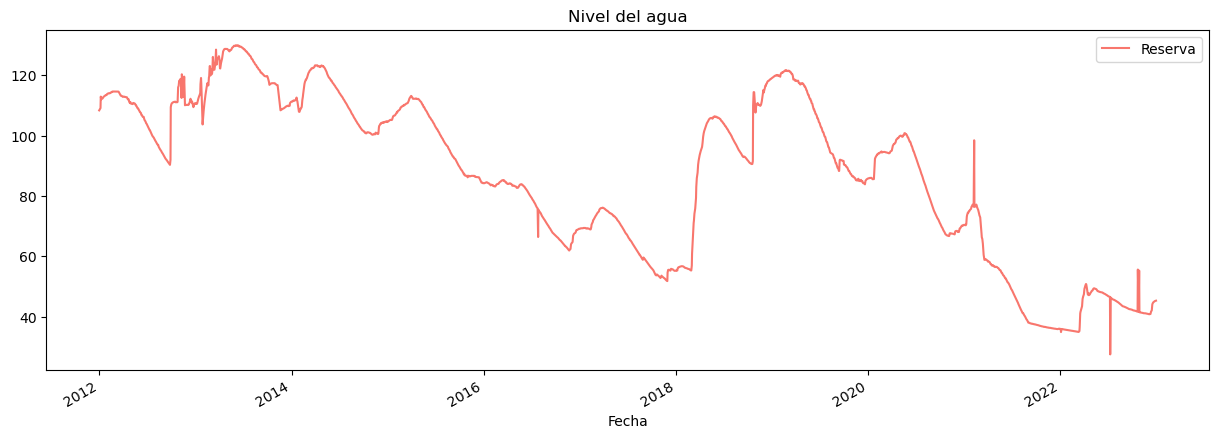

In [34]:
_ = guadDF.plot(style='-', figsize=(15,5), color=color_pal[0], title='Nivel del agua')

Vale, esto es infinitamente mejor a como estaba uniendo los diferentes años (a mano), vamos a preparar una función que lo haga, metiendo solo el nombre.

In [8]:
def concatenarAnnos(nombre: str):
    anno12 = pd.read_csv("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/"+nombre+"/"+nombre+" 2012-01-01_2012-12-30.csv", index_col=[0], parse_dates=True, dayfirst=True)
    anno13 = pd.read_csv("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/"+nombre+"/"+nombre+" 2013-01-01_2013-12-30.csv", index_col=[0], parse_dates=True, dayfirst=True)
    anno14 = pd.read_csv("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/"+nombre+"/"+nombre+" 2014-01-01_2014-12-30.csv", index_col=[0], parse_dates=True, dayfirst=True)
    anno15 = pd.read_csv("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/"+nombre+"/"+nombre+" 2015-01-01_2015-12-30.csv", index_col=[0], parse_dates=True, dayfirst=True)
    anno16 = pd.read_csv("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/"+nombre+"/"+nombre+" 2016-01-01_2016-12-30.csv", index_col=[0], parse_dates=True, dayfirst=True)
    anno17 = pd.read_csv("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/"+nombre+"/"+nombre+" 2017-01-01_2017-12-30.csv", index_col=[0], parse_dates=True, dayfirst=True)
    anno18 = pd.read_csv("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/"+nombre+"/"+nombre+" 2018-01-01_2018-12-30.csv", index_col=[0], parse_dates=True, dayfirst=True)
    anno19 = pd.read_csv("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/"+nombre+"/"+nombre+" 2019-01-01_2019-12-30.csv", index_col=[0], parse_dates=True, dayfirst=True)
    anno20 = pd.read_csv("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/"+nombre+"/"+nombre+" 2020-01-01_2020-12-30.csv", index_col=[0], parse_dates=True, dayfirst=True)
    anno21 = pd.read_csv("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/"+nombre+"/"+nombre+" 2021-01-01_2021-12-30.csv", index_col=[0], parse_dates=True, dayfirst=True)
    anno22 = pd.read_csv("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/"+nombre+"/"+nombre+" 2022-01-01_2022-12-30.csv", index_col=[0], parse_dates=True, dayfirst=True)

    annoDF = pd.concat([anno12, anno13,anno14,anno15,anno16,anno17,anno18,anno19,anno20,anno21,anno22], axis=0)
    
    #annoDF.rename(columns={'Reserva' : nombre},inplace=True) #Reactivar si se vuelve a los varios pantanos
    
    return annoDF

In [9]:
horceDF = concatenarAnnos("GUADALHORCE")
tebaDF = concatenarAnnos("GUADALTEBA")
condeDF = concatenarAnnos("CONDE DE GUADALHORCE")

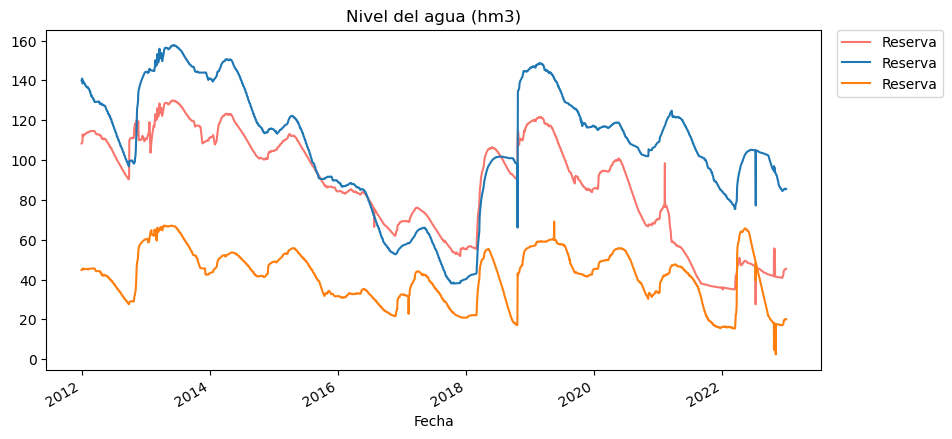

In [10]:
ax = horceDF.plot(style='-', figsize=(10,5), color=color_pal[0], title='Nivel del agua (hm3)')
tebaDF.plot(ax=ax)
condeDF.plot(ax=ax)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

Ya que tenemos los años juntos, ahora hay que juntar varias columnas juntas

In [11]:
def concatenarReservas(pantanos : list):
    sol = reduce(lambda  left,right: pd.merge(left,right,on="Fecha"), pantanos)
    return sol

In [15]:
dataset = concatenarReservas([horceDF, tebaDF, condeDF])

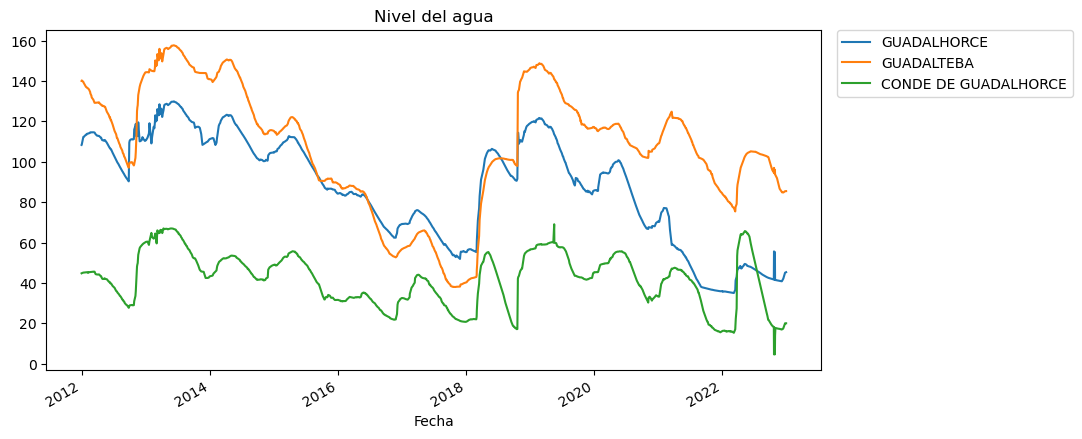

In [16]:
_ = dataset.plot(style='-', figsize=(10,5), title='Nivel del agua')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

In [17]:
dataset

,GUADALHORCE,GUADALTEBA,CONDE DE GUADALHORCE
Fecha,,,
2012-01-01,108.36,140.04,44.81
2012-01-02,108.52,140.29,44.86
2012-01-11,112.31,139.57,45.16
2012-01-13,112.33,139.11,45.16
2012-01-24,113.27,137.37,45.29
...,...,...,...
2022-12-06,40.90,84.92,17.04
2022-12-11,41.68,84.82,17.24
2022-12-14,42.17,84.80,17.59


Perfecto, ahora lo que hay que hacer es pasarle esto a la red

## Entrenamiento

In [18]:
num_epochs = 12000
learning_rate = 0.01

input_size = 3                  # 3 entradas en vez de 1
hidden_size = 4
num_layers = 1
num_classes = 3                 # 3 salidas en vez de 

train_percentage = ((7*100)/11)
seq_length = 21

gru, dataX, dataY, eficiencia = entrenarGRU(dataset, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)

  0%|          | 0/12000 [00:00<?, ?it/s]

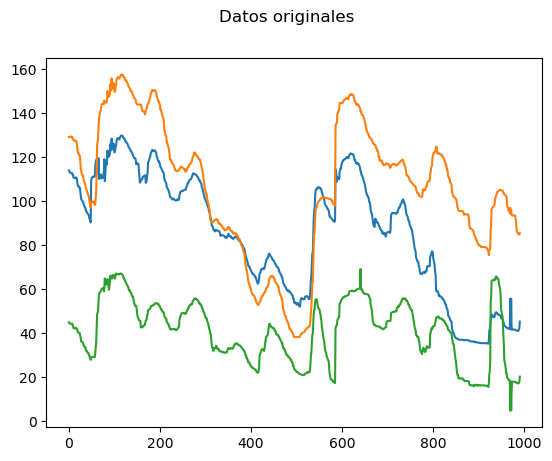

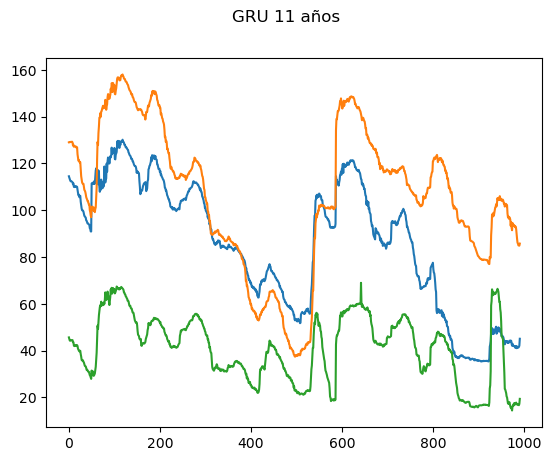

In [22]:
gru.eval()
train_predict = gru(dataX)

data_predict = train_predict.data.cpu().numpy()
dataY_plot = dataY.data.cpu().numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.plot(dataY_plot)
plt.suptitle('Datos originales')
plt.show()
plt.plot(data_predict)
plt.suptitle('GRU 11 años')
plt.show()

In [23]:
medirPrecision(gru, dataX, dataY, eficiencia)

MSE: 2.0377283096313477 MAPE: 1.2864130549132824


Me parece extremadamente raro el aumento de error de golpe, voy a hacer otra función que compruebe por pantano el error, por si no funciona la función original.

In [20]:
def medirPrecisionPorColumnas(datos, prediccion):
    
    l = len(datos[0])
    for i in range(0, l):
        mse = mean_squared_error(datos[:,i], prediccion[:,i])
        mape = mean_absolute_percentage_error(datos[:,i], prediccion[:,i])
        
        print(" Columna "+str(i)+" MSE: "+ str(mse.item()) + " MAPE: "+ str(mape.item()))

In [25]:
medirPrecisionPorColumnas(dataY_plot, data_predict)

 Columna 0 MSE: 2.0413095951080322 MAPE: 0.9285381995141506
 Columna 1 MSE: 1.909479022026062 MAPE: 0.6534537766128778
 Columna 2 MSE: 2.1623988151550293 MAPE: 2.2772474214434624


Pues si funciona correctamente, a ver si entrenando 20 veces se mantiene

In [27]:
num_epochs = 12000
learning_rate = 0.01

input_size = 3                  # 3 entradas en vez de 1
hidden_size = 4
num_layers = 1
num_classes = 3                 # 3 salidas en vez de 

train_percentage = ((7*100)/11)
seq_length = 21

for i in range(0,20):
    
    gru, dataX, dataY, eficiencia = entrenarGRU(dataset, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
    medirPrecision(gru, dataX, dataY, eficiencia)


  0%|          | 0/12000 [00:00<?, ?it/s]

MSE: 2.068497896194458 MAPE: 1.2925305403769016


  0%|          | 0/12000 [00:00<?, ?it/s]

MSE: 2.0568721294403076 MAPE: 1.3148212805390358


  0%|          | 0/12000 [00:00<?, ?it/s]

MSE: 2.1169607639312744 MAPE: 1.3214357197284698


  0%|          | 0/12000 [00:00<?, ?it/s]

MSE: 2.044633150100708 MAPE: 1.3132231310009956


  0%|          | 0/12000 [00:00<?, ?it/s]

MSE: 1.9313926696777344 MAPE: 1.2595892883837223


  0%|          | 0/12000 [00:00<?, ?it/s]

MSE: 2.0477163791656494 MAPE: 1.2428194284439087


  0%|          | 0/12000 [00:00<?, ?it/s]

MSE: 3.403604745864868 MAPE: 2.068648487329483


  0%|          | 0/12000 [00:00<?, ?it/s]

MSE: 2.0145161151885986 MAPE: 1.296047493815422


  0%|          | 0/12000 [00:00<?, ?it/s]

MSE: 2.0031962394714355 MAPE: 1.2769964523613453


  0%|          | 0/12000 [00:00<?, ?it/s]

MSE: 1.9510679244995117 MAPE: 1.2850794941186905


  0%|          | 0/12000 [00:00<?, ?it/s]

MSE: 1.989156723022461 MAPE: 1.2830045074224472


  0%|          | 0/12000 [00:00<?, ?it/s]

MSE: 2.0290403366088867 MAPE: 1.2728098779916763


  0%|          | 0/12000 [00:00<?, ?it/s]

MSE: 3.510432481765747 MAPE: 2.108108438551426


  0%|          | 0/12000 [00:00<?, ?it/s]

MSE: 1.9167014360427856 MAPE: 1.2473106384277344


  0%|          | 0/12000 [00:00<?, ?it/s]

MSE: 3.512561559677124 MAPE: 2.108781784772873


  0%|          | 0/12000 [00:00<?, ?it/s]

MSE: 2.1128883361816406 MAPE: 1.2845956720411777


  0%|          | 0/12000 [00:00<?, ?it/s]

MSE: 2.1350295543670654 MAPE: 1.3419010676443577


  0%|          | 0/12000 [00:00<?, ?it/s]

MSE: 4.82749080657959 MAPE: 2.0402219146490097


  0%|          | 0/12000 [00:00<?, ?it/s]

MSE: 3.280938148498535 MAPE: 2.040378749370575


  0%|          | 0/12000 [00:00<?, ?it/s]

MSE: 2.00183367729187 MAPE: 1.2596135959029198


Esto me extraña muchísimo, pero si es así de verdad, no merece la pena agrupar pantanos con estas redes.
Voy a comprobar con un solo pantano a ver que pasa

In [28]:
num_epochs = 12000
learning_rate = 0.01

input_size = 1
hidden_size = 4
num_layers = 1
num_classes = 1 

train_percentage = ((7*100)/11)
seq_length = 21

gru, dataX, dataY, eficiencia = entrenarGRU(horceDF, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(gru, dataX, dataY, eficiencia)
    

gru, dataX, dataY, eficiencia = entrenarGRU(tebaDF, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(gru, dataX, dataY, eficiencia)

  
gru, dataX, dataY, eficiencia = entrenarGRU(condeDF, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(gru, dataX, dataY, eficiencia)

  0%|          | 0/12000 [00:00<?, ?it/s]

MSE: 1.5043463706970215 MAPE: 0.529099628329277


  0%|          | 0/12000 [00:00<?, ?it/s]

MSE: 1.7585200071334839 MAPE: 0.6988089997321367


  0%|          | 0/12000 [00:00<?, ?it/s]

MSE: 0.8659064173698425 MAPE: 0.967167317867279


La ejecución falló en algún momento, pero creo que hay algún error en los datos de 2 de los pantanos en 2022.

Guadalteba:
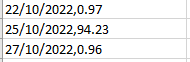

Fallo en 2 celdas

Conde del Guadalhorce:


Fallo en 2 celdas

Siendo realistas, no espero que esto solucione nada, pero no está de más solucionar estos fallos

De esta segunda ronda de ejecuciones obtengo que es peor agrupar pantanos, seguro.

Ahora quiero estudiar si el bajón en rendimiento se debe a que estoy usando 11 años en vez de 8

In [29]:
def concatenarAnnos8(nombre: str):
    anno15 = pd.read_csv("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/"+nombre+"/"+nombre+" 2015-01-01_2015-12-30.csv", index_col=[0], parse_dates=True, dayfirst=True)
    anno16 = pd.read_csv("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/"+nombre+"/"+nombre+" 2016-01-01_2016-12-30.csv", index_col=[0], parse_dates=True, dayfirst=True)
    anno17 = pd.read_csv("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/"+nombre+"/"+nombre+" 2017-01-01_2017-12-30.csv", index_col=[0], parse_dates=True, dayfirst=True)
    anno18 = pd.read_csv("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/"+nombre+"/"+nombre+" 2018-01-01_2018-12-30.csv", index_col=[0], parse_dates=True, dayfirst=True)
    anno19 = pd.read_csv("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/"+nombre+"/"+nombre+" 2019-01-01_2019-12-30.csv", index_col=[0], parse_dates=True, dayfirst=True)
    anno20 = pd.read_csv("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/"+nombre+"/"+nombre+" 2020-01-01_2020-12-30.csv", index_col=[0], parse_dates=True, dayfirst=True)
    anno21 = pd.read_csv("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/"+nombre+"/"+nombre+" 2021-01-01_2021-12-30.csv", index_col=[0], parse_dates=True, dayfirst=True)
    anno22 = pd.read_csv("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/"+nombre+"/"+nombre+" 2022-01-01_2022-12-30.csv", index_col=[0], parse_dates=True, dayfirst=True)

    annoDF = pd.concat([anno12, anno13,anno14,anno15,anno16,anno17,anno18,anno19,anno20,anno21,anno22], axis=0)
    
    annoDF.rename(columns={'Reserva' : nombre},inplace=True)
    
    return annoDF

In [30]:
horceDF_8 = concatenarAnnos("GUADALHORCE")
tebaDF_8 = concatenarAnnos("GUADALTEBA")
condeDF_8 = concatenarAnnos("CONDE DE GUADALHORCE")

In [33]:
num_epochs = 12000
learning_rate = 0.01

input_size = 1
hidden_size = 4
num_layers = 1
num_classes = 1 

train_percentage = ((7*100)/8)
seq_length = 21

gru, dataX, dataY, eficiencia = entrenarGRU(horceDF_8, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(gru, dataX, dataY, eficiencia)
    

gru, dataX, dataY, eficiencia = entrenarGRU(tebaDF_8, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(gru, dataX, dataY, eficiencia)

  
gru, dataX, dataY, eficiencia = entrenarGRU(condeDF_8, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(gru, dataX, dataY, eficiencia)

  0%|          | 0/12000 [00:00<?, ?it/s]

MSE: 1.566949725151062 MAPE: 0.5554348230361938


  0%|          | 0/12000 [00:00<?, ?it/s]

MSE: 1.2883950471878052 MAPE: 0.3228927496820688


  0%|          | 0/12000 [00:00<?, ?it/s]

MSE: 0.9294818043708801 MAPE: 1.348328497260809


El rendimiento es peor en estos pantanos que en el original de la Viñuela. Solo se me ocurre que el ajuste de hiperparámetros realizado provoque que la red esté mucho mejor preparada para el pantano anterior que para estos.
Vamos a realizar un rápido ajuste para ver como reacciona el sistema, empezando por los hiperparámetros originales

In [34]:
num_epochs = 15000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1
num_classes = 1 

train_percentage = ((7*100)/8)
seq_length = 15

gru, dataX, dataY, eficiencia = entrenarGRU(horceDF_8, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(gru, dataX, dataY, eficiencia)
    

gru, dataX, dataY, eficiencia = entrenarGRU(tebaDF_8, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(gru, dataX, dataY, eficiencia)

  
gru, dataX, dataY, eficiencia = entrenarGRU(condeDF_8, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(gru, dataX, dataY, eficiencia)

  0%|          | 0/15000 [00:00<?, ?it/s]

MSE: 1.6245737075805664 MAPE: 0.5534323863685131


  0%|          | 0/15000 [00:00<?, ?it/s]

MSE: 2.855910062789917 MAPE: 1.0843215510249138


  0%|          | 0/15000 [00:00<?, ?it/s]

MSE: 1.1264506578445435 MAPE: 1.3951738364994526


Igual o peor, vamos a cambiar un poco más

In [35]:
num_epochs = 15000
learning_rate = 0.01

input_size = 1
hidden_size = 6
num_layers = 1
num_classes = 1 

train_percentage = ((7*100)/8)
seq_length = 15

gru, dataX, dataY, eficiencia = entrenarGRU(horceDF_8, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(gru, dataX, dataY, eficiencia)
    

gru, dataX, dataY, eficiencia = entrenarGRU(tebaDF_8, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(gru, dataX, dataY, eficiencia)

  
gru, dataX, dataY, eficiencia = entrenarGRU(condeDF_8, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(gru, dataX, dataY, eficiencia)

  0%|          | 0/15000 [00:00<?, ?it/s]

MSE: 1.5341368913650513 MAPE: 0.5625859368592501


  0%|          | 0/15000 [00:00<?, ?it/s]

MSE: 1.0832571983337402 MAPE: 0.3394579282030463


  0%|          | 0/15000 [00:00<?, ?it/s]

MSE: 1.0081658363342285 MAPE: 1.2004767544567585


In [36]:
num_epochs = 15000
learning_rate = 0.01

input_size = 1
hidden_size = 6
num_layers = 1
num_classes = 1 

train_percentage = ((7*100)/8)
seq_length = 21

gru, dataX, dataY, eficiencia = entrenarGRU(horceDF_8, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(gru, dataX, dataY, eficiencia)
    

gru, dataX, dataY, eficiencia = entrenarGRU(tebaDF_8, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(gru, dataX, dataY, eficiencia)

  
gru, dataX, dataY, eficiencia = entrenarGRU(condeDF_8, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(gru, dataX, dataY, eficiencia)

  0%|          | 0/15000 [00:00<?, ?it/s]

MSE: 1.627400279045105 MAPE: 0.8024438284337521


  0%|          | 0/15000 [00:00<?, ?it/s]

MSE: 1.120575189590454 MAPE: 0.33243903890252113


  0%|          | 0/15000 [00:00<?, ?it/s]

MSE: 1.1444281339645386 MAPE: 1.3823037035763264


In [37]:
num_epochs = 15000
learning_rate = 0.01

input_size = 1
hidden_size = 6
num_layers = 1
num_classes = 1 

train_percentage = ((7*100)/8)
seq_length = 28

gru, dataX, dataY, eficiencia = entrenarGRU(horceDF_8, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(gru, dataX, dataY, eficiencia)
    

gru, dataX, dataY, eficiencia = entrenarGRU(tebaDF_8, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(gru, dataX, dataY, eficiencia)

  
gru, dataX, dataY, eficiencia = entrenarGRU(condeDF_8, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(gru, dataX, dataY, eficiencia)

  0%|          | 0/15000 [00:00<?, ?it/s]

MSE: 4.692038536071777 MAPE: 1.785193383693695


  0%|          | 0/15000 [00:00<?, ?it/s]

MSE: 1.2804574966430664 MAPE: 0.32577968668192625


  0%|          | 0/15000 [00:00<?, ?it/s]

MSE: 0.9666728377342224 MAPE: 1.2362691573798656


In [38]:
num_epochs = 15000
learning_rate = 0.01

input_size = 1
hidden_size = 6
num_layers = 1
num_classes = 1 

train_percentage = ((7*100)/8)
seq_length = 7

gru, dataX, dataY, eficiencia = entrenarGRU(horceDF_8, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(gru, dataX, dataY, eficiencia)
    

gru, dataX, dataY, eficiencia = entrenarGRU(tebaDF_8, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(gru, dataX, dataY, eficiencia)

  
gru, dataX, dataY, eficiencia = entrenarGRU(condeDF_8, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(gru, dataX, dataY, eficiencia)

  0%|          | 0/15000 [00:00<?, ?it/s]

MSE: 1.426770806312561 MAPE: 0.542155047878623


  0%|          | 0/15000 [00:00<?, ?it/s]

MSE: 1.0514280796051025 MAPE: 0.29651059303432703


  0%|          | 0/15000 [00:00<?, ?it/s]

MSE: 0.8541494011878967 MAPE: 1.1784697882831097


In [39]:
num_epochs = 12000
learning_rate = 0.01

input_size = 1
hidden_size = 6
num_layers = 1
num_classes = 1 

train_percentage = ((7*100)/8)
seq_length = 7

gru, dataX, dataY, eficiencia = entrenarGRU(horceDF_8, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(gru, dataX, dataY, eficiencia)
    

gru, dataX, dataY, eficiencia = entrenarGRU(tebaDF_8, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(gru, dataX, dataY, eficiencia)

  
gru, dataX, dataY, eficiencia = entrenarGRU(condeDF_8, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(gru, dataX, dataY, eficiencia)

  0%|          | 0/12000 [00:00<?, ?it/s]

MSE: 1.6900545358657837 MAPE: 0.6793402601033449


  0%|          | 0/12000 [00:00<?, ?it/s]

MSE: 1.5456774234771729 MAPE: 0.6286526564508677


  0%|          | 0/12000 [00:00<?, ?it/s]

MSE: 1.2630709409713745 MAPE: 2.1210478618741035


In [40]:
num_epochs = 15000
learning_rate = 0.01

input_size = 1
hidden_size = 6
num_layers = 1
num_classes = 1 

train_percentage = ((7*100)/8)
seq_length = 7

gru, dataX, dataY, eficiencia = entrenarGRU(horceDF_8, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(gru, dataX, dataY, eficiencia)
    

gru, dataX, dataY, eficiencia = entrenarGRU(tebaDF_8, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(gru, dataX, dataY, eficiencia)

  
gru, dataX, dataY, eficiencia = entrenarGRU(condeDF_8, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(gru, dataX, dataY, eficiencia)

  0%|          | 0/15000 [00:00<?, ?it/s]

MSE: 1.5843307971954346 MAPE: 0.5629603751003742


  0%|          | 0/15000 [00:00<?, ?it/s]

MSE: 1.6523244380950928 MAPE: 0.32969440799206495


  0%|          | 0/15000 [00:00<?, ?it/s]

MSE: 1.0089560747146606 MAPE: 1.3367360457777977


In [41]:
num_epochs = 15000
learning_rate = 0.01

input_size = 1
hidden_size = 3
num_layers = 1
num_classes = 1 

train_percentage = ((7*100)/8)
seq_length = 7

gru, dataX, dataY, eficiencia = entrenarGRU(horceDF_8, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(gru, dataX, dataY, eficiencia)
    

gru, dataX, dataY, eficiencia = entrenarGRU(tebaDF_8, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(gru, dataX, dataY, eficiencia)

  
gru, dataX, dataY, eficiencia = entrenarGRU(condeDF_8, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(gru, dataX, dataY, eficiencia)

  0%|          | 0/15000 [00:00<?, ?it/s]

MSE: 1.5668220520019531 MAPE: 0.5537397228181362


  0%|          | 0/15000 [00:00<?, ?it/s]

MSE: 1.259630560874939 MAPE: 0.5679512396454811


  0%|          | 0/15000 [00:00<?, ?it/s]

MSE: 1.0135623216629028 MAPE: 1.2938201427459717


In [42]:
num_epochs = 15000
learning_rate = 0.01

input_size = 1
hidden_size = 8
num_layers = 1
num_classes = 1 

train_percentage = ((7*100)/8)
seq_length = 7

gru, dataX, dataY, eficiencia = entrenarGRU(horceDF_8, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(gru, dataX, dataY, eficiencia)
    

gru, dataX, dataY, eficiencia = entrenarGRU(tebaDF_8, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(gru, dataX, dataY, eficiencia)

  
gru, dataX, dataY, eficiencia = entrenarGRU(condeDF_8, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(gru, dataX, dataY, eficiencia)

  0%|          | 0/15000 [00:00<?, ?it/s]

MSE: 1.4678313732147217 MAPE: 0.534782512113452


  0%|          | 0/15000 [00:00<?, ?it/s]

MSE: 1.9098577499389648 MAPE: 0.5252114497125149


  0%|          | 0/15000 [00:00<?, ?it/s]

MSE: 0.7994914650917053 MAPE: 0.89670205488801


Este último es el que mejor balance ha tenido entre los 3, pero sigue siendo bastante malo en comparación.
Voy a encontrar la correlación entre ellos.

In [47]:
print('Correlación Pearson: ', horceDF_8['GUADALHORCE'].corr(tebaDF_8['GUADALTEBA'], method='pearson'))
print('Correlación spearman: ', horceDF_8['GUADALHORCE'].corr(condeDF_8['CONDE DE GUADALHORCE'], method='pearson'))
print('Correlación kendall: ', tebaDF_8['GUADALTEBA'].corr(condeDF_8['CONDE DE GUADALHORCE'], method='pearson'))

Correlación Pearson:  0.7264441429660471
Correlación spearman:  0.6908148050401609
Correlación kendall:  0.733783904342932


Tienen una correlación relativamente elevada, y aún así no hay manera de que en una sola red se predigan todos bien, va a haber que usar una por pantano.
Por último voy a ver si LSTM funciona mejor

In [48]:
num_epochs = 9000
learning_rate = 0.01

input_size = 1
hidden_size = 6
num_layers = 1
num_classes = 1 

train_percentage = ((7*100)/8)
seq_length = 28

lstm, dataX, dataY, eficiencia = entrenarLSTM(horceDF_8, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(lstm, dataX, dataY, eficiencia)
    

lstm, dataX, dataY, eficiencia = entrenarLSTM(tebaDF_8, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(lstm, dataX, dataY, eficiencia)

  
lstm, dataX, dataY, eficiencia = entrenarLSTM(condeDF_8, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)
medirPrecision(lstm, dataX, dataY, eficiencia)

  0%|          | 0/9000 [00:00<?, ?it/s]

MSE: 1.566019892692566 MAPE: 0.5622955970466137


  0%|          | 0/9000 [00:00<?, ?it/s]

MSE: 1.4850826263427734 MAPE: 0.37026461213827133


  0%|          | 0/9000 [00:00<?, ?it/s]

MSE: 1.5086843967437744 MAPE: 2.602832578122616


Lo mismo (un poquito mejor tbh).

# Datos Meteorológicos

Ya que hemos llegado a la conclusión de que los datos de pantanos cercanos no nos sirven para nada, vamos a comprobar con los datos meteorológicos. (Aunque obtenerlos y formatearlos haya sido una tortura)

In [12]:
asignaciones = json.loads(open("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/asignaciones.json", "r", encoding='utf8').read())

In [13]:
print(asignaciones.get("GUADALHORCE"))

ANTEQUERA


Esa es la estación meteorológica correspondiente

In [11]:
estacion = asignaciones.get("GUADALHORCE")
df = pd.read_json("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/AEMET/" + estacion + "/" + estacion +" 2012-01-01_2012-12-30.json", convert_dates=True)
df.set_index('fecha',inplace=True)

In [12]:
df.head()

,indicativo,nombre,provincia,altitud,tmed,prec,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha,presMax,horaPresMax,presMin,horaPresMin
fecha,,,,,,,,,,,,,,,,,,
2012-01-01,6106X,ANTEQUERA,MALAGA,408,"8,4","0,0","-0,1",06:50,"16,9",14:00,32.0,"0,6","4,7",14:20,"981,6",24,"978,3",15
2012-01-02,6106X,ANTEQUERA,MALAGA,408,"9,5","0,0","5,1",00:10,"13,9",15:40,29.0,"2,2","7,2",12:40,"985,1",23,"981,1",01
2012-01-03,6106X,ANTEQUERA,MALAGA,408,"7,6","0,0","-1,3",07:50,"16,4",14:50,99.0,"1,4","5,0",17:50,"985,3",11,"982,0",15
2012-01-04,6106X,ANTEQUERA,MALAGA,408,"9,0","0,0","-0,7",07:50,"18,6",15:20,34.0,"0,6","5,6",17:40,"985,5",10,"981,6",17
2012-01-05,6106X,ANTEQUERA,MALAGA,408,"9,2","0,0","-1,0",05:00,"19,4",14:40,33.0,"0,6","3,9",14:00,"984,1",10,"980,2",16


Muy bien, ahora a conseguir los diferentes años a la vez

In [14]:
def concatenarEstaciones11(estacion:str):
    
    
    anno12 = pd.read_json("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/AEMET/" + estacion + "/" + estacion +" 2012-01-01_2012-12-30.json", convert_dates=True)
    anno12['fecha'] = pd.to_datetime(anno12['fecha'], utc = False)
    anno12.set_index('fecha',inplace=True)
    anno13 = pd.read_json("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/AEMET/" + estacion + "/" + estacion +" 2013-01-01_2013-12-30.json", convert_dates=True)
    anno13['fecha'] = pd.to_datetime(anno13['fecha'], utc = False)
    anno13.set_index('fecha',inplace=True)
    anno14 = pd.read_json("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/AEMET/" + estacion + "/" + estacion +" 2014-01-01_2014-12-30.json", convert_dates=True)
    anno14['fecha'] = pd.to_datetime(anno14['fecha'], utc = False)
    anno14.set_index('fecha',inplace=True)
    anno15 = pd.read_json("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/AEMET/" + estacion + "/" + estacion +" 2015-01-01_2015-12-30.json", convert_dates=True)
    anno15['fecha'] = pd.to_datetime(anno15['fecha'], utc = False)
    anno15.set_index('fecha',inplace=True)
    anno16 = pd.read_json("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/AEMET/" + estacion + "/" + estacion +" 2016-01-01_2016-12-30.json", convert_dates=True)
    anno16['fecha'] = pd.to_datetime(anno16['fecha'], utc = False)
    anno16.set_index('fecha',inplace=True)
    anno17 = pd.read_json("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/AEMET/" + estacion + "/" + estacion +" 2017-01-01_2017-12-30.json", convert_dates=True)
    anno17['fecha'] = pd.to_datetime(anno17['fecha'], utc = False)
    anno17.set_index('fecha',inplace=True)
    anno18 = pd.read_json("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/AEMET/" + estacion + "/" + estacion +" 2018-01-01_2018-12-30.json", convert_dates=True)
    anno18['fecha'] = pd.to_datetime(anno18['fecha'], utc = False)
    anno18.set_index('fecha',inplace=True)
    anno19 = pd.read_json("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/AEMET/" + estacion + "/" + estacion +" 2019-01-01_2019-12-30.json", convert_dates=True)
    anno19['fecha'] = pd.to_datetime(anno19['fecha'], utc = False)
    anno19.set_index('fecha',inplace=True)
    anno20 = pd.read_json("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/AEMET/" + estacion + "/" + estacion +" 2020-01-01_2020-12-30.json", convert_dates=True)
    anno20['fecha'] = pd.to_datetime(anno20['fecha'], utc = False)
    anno20.set_index('fecha',inplace=True)
    anno21 = pd.read_json("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/AEMET/" + estacion + "/" + estacion +" 2021-01-01_2021-12-30.json", convert_dates=True)
    anno21['fecha'] = pd.to_datetime(anno21['fecha'], utc = False)
    anno21.set_index('fecha',inplace=True)
    anno22 = pd.read_json("C:/Users/juanm/Desktop/Asignaturas/Cuarto/TFG/Scrapper/AEMET/" + estacion + "/" + estacion +" 2022-01-01_2022-12-30.json", convert_dates=True)
    anno22['fecha'] = pd.to_datetime(anno22['fecha'], utc = False)
    anno22.set_index('fecha',inplace=True)
    
    annoDF = pd.concat([anno12, anno13,anno14,anno15,anno16,anno17,anno18,anno19,anno20,anno21,anno22], axis=0)
    
    annoDF.drop_duplicates(keep='first')
    annoDF.index.names = ['Fecha']
    
    return annoDF

In [15]:
antequeraDF11 = concatenarEstaciones11(asignaciones.get("GUADALHORCE"))

In [16]:
antequeraDF11.to_csv("C:/Users/juanm/Desktop/estacion.csv")
horceDF.to_csv("C:/Users/juanm/Desktop/pantano.csv")

Pues ahora me entero de que faltan días en ambos grupos de datos, perfecto, haré el merge y a ver que sale

In [17]:
dataset = concatenarReservas([horceDF, antequeraDF11])

Esto elimina un montón de filas, las que no tengan índice compartido

In [18]:
dataset

,Reserva,indicativo,nombre,provincia,altitud,tmed,prec,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha,presMax,horaPresMax,presMin,horaPresMin
Fecha,,,,,,,,,,,,,,,,,,,
2012-01-01,108.36,6106X,ANTEQUERA,MALAGA,408,"8,4","0,0","-0,1",06:50,"16,9",14:00,32.0,"0,6","4,7",14:20,"981,6",24,"978,3",15
2012-01-02,108.52,6106X,ANTEQUERA,MALAGA,408,"9,5","0,0","5,1",00:10,"13,9",15:40,29.0,"2,2","7,2",12:40,"985,1",23,"981,1",01
2012-01-03,108.64,6106X,ANTEQUERA,MALAGA,408,"7,6","0,0","-1,3",07:50,"16,4",14:50,99.0,"1,4","5,0",17:50,"985,3",11,"982,0",15
2012-01-06,109.13,6106X,ANTEQUERA,MALAGA,408,"9,0","0,0","-1,2",07:30,"19,1",15:00,34.0,"0,3","5,3",16:10,"981,0",Varias,"977,4",15
2012-01-07,112.91,6106X,ANTEQUERA,MALAGA,408,"10,2","0,0","2,2",07:00,"18,2",13:40,99.0,"2,5","8,6",Varias,"980,4",10,"977,5",16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-18,41.18,6106X,ANTEQUERA,MALAGA,408,"11,8","1,6","8,1",23:10,"15,5",00:10,31.0,"1,9","10,0",15:50,"972,2",24,"965,9",13
2022-11-19,41.17,6106X,ANTEQUERA,MALAGA,408,"9,8","0,0","6,2",07:30,"13,5",Varias,31.0,"1,7","9,2",10:50,"976,0",23,"971,5",02
2022-11-22,41.12,6106X,ANTEQUERA,MALAGA,408,"12,2","0,1","9,8",07:40,"14,6",14:20,99.0,"1,9","7,8",Varias,"974,6",11,"972,2",04


In [18]:
dataset.to_csv("C:/Users/juanm/Desktop/merged.csv")

Si, sin duda faltan datos , vamos a borrar primero las columnas que no me importan, y luego las filas donde falten cosas, que remedio.

In [19]:
def prepararDataset(df):
    del df["indicativo"]
    del df["nombre"]
    del df["provincia"]
    del df["altitud"]
    del df["tmin"]
    del df["horatmin"]
    del df["tmax"]
    del df["horatmax"]
    del df["dir"]
    del df["velmedia"]
    del df["racha"]
    del df["horaracha"]
    del df["presMax"]
    del df["horaPresMax"]
    del df["presMin"]
    del df["horaPresMin"]
    
    df['tmed'] = df['tmed'].str.replace(',','.')
    df['prec'] = df['prec'].str.replace(',','.')
    
    df['tmed']=df['tmed'].astype(float)
    df['prec']=df['prec'].astype(float)
    
    return df

In [20]:
dataset = prepararDataset(dataset)

In [21]:
dataset.head(50)

,Reserva,tmed,prec
Fecha,,,
2012-01-01,108.36,8.4,0.0
2012-01-02,108.52,9.5,0.0
2012-01-03,108.64,7.6,0.0
2012-01-06,109.13,9.0,0.0
2012-01-07,112.91,10.2,0.0
2012-01-09,112.02,8.0,0.0
2012-01-11,112.31,11.4,0.0
2012-01-17,112.78,8.8,0.0
2012-01-18,112.91,6.9,0.0


Poco, de momento, luego veremos si añadiendo más datos sale mejor la cosa

In [21]:
dataset.dropna(axis=0, inplace=True)

In [23]:
dataset.to_csv("C:/Users/juanm/Desktop/merged.csv")

In [22]:
dataset.dtypes

Reserva    float64
tmed       float64
prec       float64
dtype: object

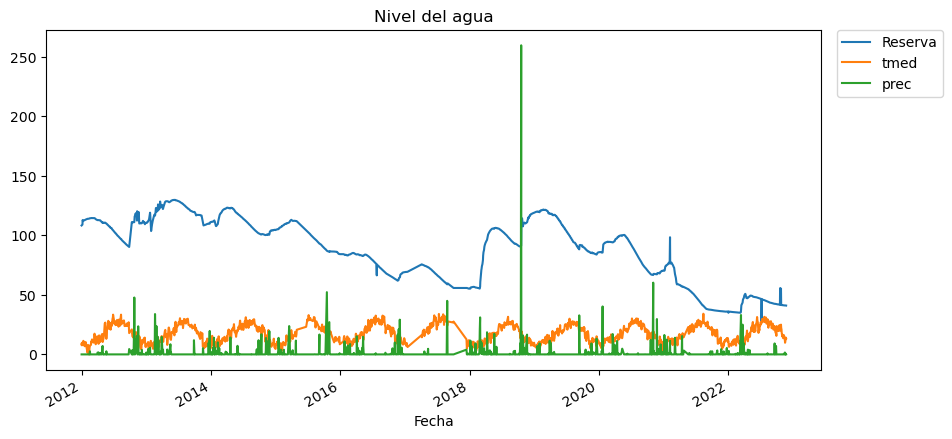

In [23]:
_ = dataset.plot(style='-', figsize=(10,5), title='Nivel del agua')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

Se me hace a mi como que esto es muy poco no?

In [26]:
horceDF

,Reserva
Fecha,
2012-01-01,108.36
2012-01-02,108.52
2012-01-03,108.64
2012-01-06,109.13
2012-01-07,112.91
...,...
2022-12-22,44.96
2022-12-24,45.12
2022-12-26,45.23


Bueno, 400 filas menos, a ver si merece la pena

## Entrenamiento

In [31]:
num_epochs = 12000
learning_rate = 0.01

input_size = 3                  # 3 entradas en vez de 1
hidden_size = 4
num_layers = 1
num_classes = 3                 

train_percentage = ((7*100)/11)
seq_length = 21

gru, dataX, dataY, eficiencia = entrenarGRU(dataset, train_percentage, num_epochs, seq_length, learning_rate, input_size, hidden_size, num_layers, num_classes)

  0%|          | 0/12000 [00:00<?, ?it/s]

In [25]:
gru.eval()
train_predict = gru(dataX)

In [26]:
data_predict = train_predict.data.cpu().numpy()
#data_predict = sc.inverse_transform(data_predict) 
train_predict_new = np.zeros(shape=(len(train_predict), 3))
train_predict_new[:,0] = data_predict[:,0]
trainPredict = sc.inverse_transform(train_predict_new )[:,0]

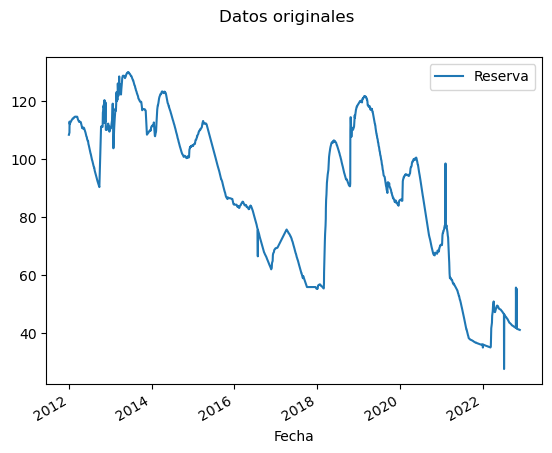

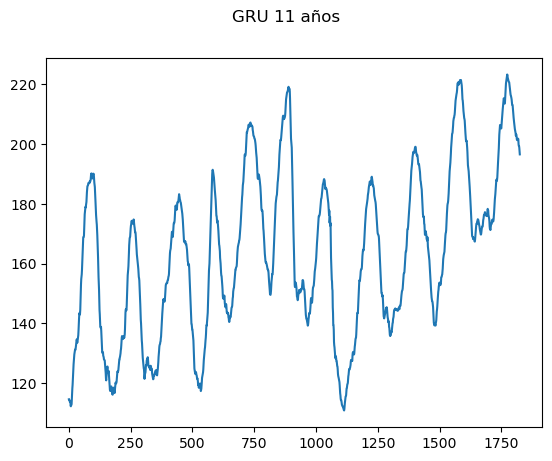

In [27]:
dataset[["Reserva"]].plot()
plt.suptitle('Datos originales')
plt.show()
plt.plot(trainPredict)
plt.suptitle('GRU 11 años')
plt.show()